<a href="https://colab.research.google.com/github/lohaoxi/basic-gans/blob/master/vanilla_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time
import os
import torch
import torchvision
import numpy as np
from torchvision.datasets import MNIST
import torch.nn as nn
import torch.nn.functional as F
from  torch.utils.data import DataLoader
from matplotlib import pyplot as plt
% matplotlib inline


print(torch.__version__)
print(torchvision.__version__)
print(torch.cuda.is_available())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if not os.path.exists('visuals'):
    os.mkdir('visuals')

1.9.0+cu102
0.10.0+cu102
True


In [2]:
class FlattenTransform:
    def __call__(self, inputs):
        return inputs.view(inputs.shape[0], -1)

In [3]:
BATCH_SIZE = 32
noise_dim = 100

train_data = MNIST('./data/mnist', 
                   train = True,
                   download = True,
                   transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                               FlattenTransform()]))
test_data = MNIST('./data/mnist', 
                  train = False,
                  download = True,
                  transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                              FlattenTransform()]))

train_loader = DataLoader(dataset = train_data,
                          batch_size = BATCH_SIZE,
                          shuffle = True,
                          num_workers = 4)

test_loader = DataLoader(dataset = test_data,
                         batch_size = BATCH_SIZE,
                         shuffle = False,
                         num_workers = 4)


Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw




Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw




Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw




Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid poten

In [41]:
class Generator(nn.Module):

    def __init__(self):
        super(Generator, self).__init__()
        self.fc_g1 = nn.Linear(in_features = noise_dim, out_features = 1200, bias = True)
        self.fc_g2 = nn.Linear(in_features = 1200, out_features = 1200, bias = True)
        self.fc_g3 = nn.Linear(in_features = 1200, out_features = 1200, bias = True)
        self.fc_g4 = nn.Linear(in_features = 1200, out_features = 784, bias = True)
        self.relu_g1 = nn.ReLU()
        self.relu_g2 = nn.ReLU()
        self.relu_g3 = nn.ReLU()
        self.dropout_g1 = nn.Dropout()
        self.dropout_g2 = nn.Dropout()
        self.dropout_g3 = nn.Dropout()

    def forward(self, src):
        src = src.view(src.size(0), -1)
        src = self.fc_g1(src)
        src=  self.relu_g1(src)
        src = self.dropout_g1(src)
        src = self.fc_g2(src)
        src = self.relu_g2(src)
        src = self.dropout_g2(src)
        src = self.fc_g3(src)
        src = self.relu_g3(src)
        src = self.dropout_g3(src)
        src = self.fc_g4(src)
        return F.sigmoid(src)

class Maxout(nn.Module):
    def __init__(self, n_pieces):
        super(Maxout, self).__init__()
        self.n_pieces = n_pieces

    def forward(self, src):
        # src [batch_size, 625]
        src = src.view(*src.shape[:1], 
                       src.shape[1] // self.n_pieces, 
                       self.n_pieces)
        # src [batch_size, 625 // n_pieces, n_pieces]
        src, _ = src.max(dim = 2)
        return src

class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc_d1 = nn.Linear(in_features = 784, out_features = 625, bias = True)
        self.fc_d2 = nn.Linear(in_features = 125, out_features = 625, bias = True)
        self.fc_d3 = nn.Linear(in_features = 125, out_features = 1, bias = True)
        self.maxout_d1 = Maxout(n_pieces = 5)
        self.maxout_d2 = Maxout(n_pieces = 5)

    def forward(self, src):
        src = src.view(src.size(0), -1)
        src = self.fc_d1(src)
        src = self.maxout_d1(src)
        src = self.fc_d2(src)
        src = self.maxout_d2(src)
        src = self.fc_d3(src)
        return F.sigmoid(src)







In [42]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

generator_optimizer = torch.optim.SGD(generator.parameters(),
                                      lr = 0.0002,
                                      momentum = 0.5)
discriminator_optimizer = torch.optim.SGD(discriminator.parameters(),
                                          lr = 0.0002,
                                          momentum = 0.5)



criterion = torch.nn.BCELoss()

print(generator)
print(discriminator)

Generator(
  (fc_g1): Linear(in_features=100, out_features=1200, bias=True)
  (fc_g2): Linear(in_features=1200, out_features=1200, bias=True)
  (fc_g3): Linear(in_features=1200, out_features=1200, bias=True)
  (fc_g4): Linear(in_features=1200, out_features=784, bias=True)
  (relu_g1): ReLU()
  (relu_g2): ReLU()
  (relu_g3): ReLU()
  (dropout_g1): Dropout(p=0.5, inplace=False)
  (dropout_g2): Dropout(p=0.5, inplace=False)
  (dropout_g3): Dropout(p=0.5, inplace=False)
)
Discriminator(
  (fc_d1): Linear(in_features=784, out_features=625, bias=True)
  (fc_d2): Linear(in_features=125, out_features=625, bias=True)
  (fc_d3): Linear(in_features=125, out_features=1, bias=True)
  (maxout_d1): Maxout()
  (maxout_d2): Maxout()
)


In [43]:
real_trg = torch.ones(BATCH_SIZE, 1).to(device)
fake_trg = torch.zeros(BATCH_SIZE, 1).to(device)

test_set = torch.randn(16, noise_dim).to(device)


In [44]:
EPOCHS = 512
K = 8
steps = len(train_loader) // BATCH_SIZE
start_time = time.time()

for epoch in range(EPOCHS):

    epoch_DX = 0
    epoch_DGz = 0
    epoch_loss = 0
       
    for i, (src, _) in enumerate(train_loader):
        
        if i == steps: break

        # Train Discriminator

        for _ in range(K):
        
            real_src = src.to(device)

            fake_src = generator(torch.randn(BATCH_SIZE, noise_dim).to(device))

            discriminator_optimizer.zero_grad()

            real_outputs = discriminator(real_src)
            fake_outputs = discriminator(fake_src)

            DX = criterion(real_outputs, real_trg)
            DGz = criterion(fake_outputs, fake_trg)

            DX.backward()
            DGz.backward()

            discriminator_optimizer.step()

            epoch_DX += DX
            epoch_DGz += DGz

        # Train Generator
        z = torch.randn(BATCH_SIZE, noise_dim).to(device)

        generator.zero_grad()

        outputs = discriminator(generator(z))

        loss = criterion(outputs, real_trg)

        loss.backward()

        generator_optimizer.step()
        
        epoch_loss += loss        
    
    print("Epoch: {:04}, DX: {:0.4f}, DGz: {:0.4f}, Loss: {:0.4f}, Elapsed Time: {:0.6f}".format(epoch + 1, 
                                                                                                 epoch_DX / steps / 8,
                                                                                                 epoch_DGz / steps / 8,
                                                                                                 epoch_loss / steps, 
                                                                                                 time.time() - start_time))
    if epoch % 10 == 0:

        generated = generator(test_set).detach().cpu().view(-1, 1, 28, 28)

        grid = torchvision.utils.save_image(generated, 
                                            os.path.join('visuals', '{}.jpg'.format(str(epoch).zfill(6))),
                                            nrow = 4,
                                            padding = 10,
                                            pad_value = 1)
                                                                                       


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 0001, DX: 0.7224, DGz: 0.3907, Loss: 1.1794, Elapsed Time: 1.920604
Epoch: 0002, DX: 0.6013, DGz: 0.1876, Loss: 1.7820, Elapsed Time: 3.853195
Epoch: 0003, DX: 0.4167, DGz: 0.1124, Loss: 2.2563, Elapsed Time: 5.767807
Epoch: 0004, DX: 0.2624, DGz: 0.0686, Loss: 2.7285, Elapsed Time: 7.683201
Epoch: 0005, DX: 0.1670, DGz: 0.0429, Loss: 3.1829, Elapsed Time: 9.613367
Epoch: 0006, DX: 0.1121, DGz: 0.0284, Loss: 3.5862, Elapsed Time: 11.524179
Epoch: 0007, DX: 0.0781, DGz: 0.0201, Loss: 3.9233, Elapsed Time: 13.379636
Epoch: 0008, DX: 0.0576, DGz: 0.0150, Loss: 4.2167, Elapsed Time: 15.268850
Epoch: 0009, DX: 0.0443, DGz: 0.0116, Loss: 4.4712, Elapsed Time: 17.136194
Epoch: 0010, DX: 0.0375, DGz: 0.0093, Loss: 4.6845, Elapsed Time: 19.003248
Epoch: 0011, DX: 0.0304, DGz: 0.0077, Loss: 4.8691, Elapsed Time: 20.880045
Epoch: 0012, DX: 0.0258, DGz: 0.0066, Loss: 5.0302, Elapsed Time: 22.747103
Epoch: 0013, DX: 0.0224, DGz: 0.0057, Loss: 5.1694, Elapsed Time: 24.580816
Epoch: 0014, DX: 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


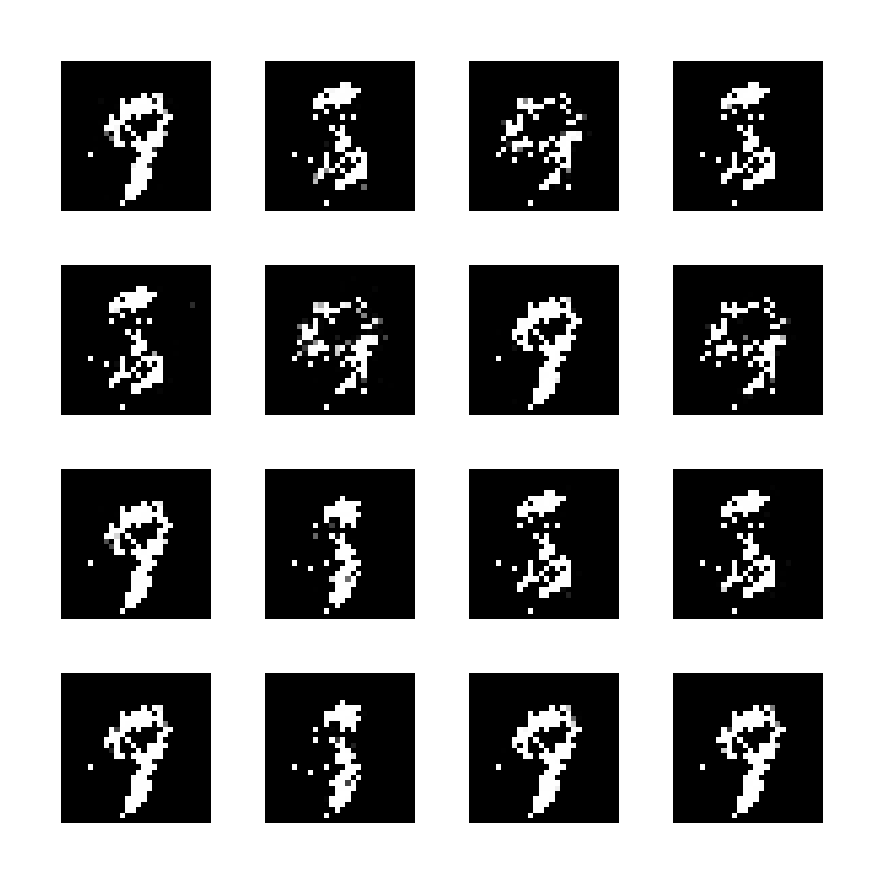

In [45]:
generated = generator(test_set).detach().cpu().view(-1, 1, 28, 28)

grid = torchvision.utils.make_grid(generated,
                                   nrow = 4,
                                   padding = 10,
                                   pad_value = 1)

img = np.transpose(grid.numpy(), (1, 2, 0))

fig = plt.figure(figsize = (16, 16))
plt.axis("off")
plt.imshow(img);

In [ ]:
from torchvision.models import inception_v3